***
## notebook config

In [2]:
ON_COLAB = False
ASSESS = True

In [3]:
if ON_COLAB:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive', force_remount=True)
    
    !pip install --upgrade kaggle > /dev/null 2>&1
    !mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    
    !free -h
    
    !pip install --upgrade category_encoders > /dev/null 2>&1
    !pip install --upgrade tsforest > /dev/null 2>&1
    !pip install --upgrade lightgbm > /dev/null 2>&1
    !pip install --upgrade optuna > /dev/null 2>&1

In [4]:
if ON_COLAB:
    !kaggle datasets download -d mavillan/meli-2021 --force --unzip
    !ls -halt
    input_path = "./"
    print("input_path:", input_path)
else:
    input_path = "../data"
    print("input_path:", input_path)

input_path: ../data


In [5]:
SEED = 19
SUB_NBR = "05"

***

In [6]:
from copy import deepcopy
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy import stats
import time

import category_encoders as ce
import xgboost as xgb
from tqdm import tqdm
from tsforest.forecast import XGBoostForecaster
import optuna

np.random.seed(SEED)
pd.set_option('display.max_columns', None)

In [7]:
def reduce_mem_usage(df, verbose=False):
    """
    Utility function to reduce the memory usage of pandas dataframes
    
    Parameters
    ----------
    df: pandas.Dataframe
    verbose: Boolean
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
class RMSSE():
    def __init__(self, valid_dataframe, scales_dataframe):
        self.valid_dataframe = valid_dataframe
        self.scales_dataframe = scales_dataframe
        self.apply_inverse = False
        if set(["y_mean","y_std"]) <= set(valid_dataframe.columns):
            self.apply_inverse = True

    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        if not self.apply_inverse:  
            valid_dataframe["ypred"] = predictions
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        else:
            valid_dataframe["ypred"] = valid_dataframe["y_std"]*predictions + valid_dataframe["y_mean"]
            valid_dataframe["sq_error"] = valid_dataframe.eval("(y_raw-ypred)**2")
        mse = valid_dataframe.groupby("sku")["sq_error"].mean().reset_index(name="mse")
        mrg = pd.merge(mse, self.scales_dataframe, how="inner", on="sku")
        return mrg.eval("sqrt(mse)/scale").mean()

    def evaluate(self, pred: np.ndarray, dtrain: xgb.DMatrix):
        metric = self._evaluate(pred)
        return "rmsse", metric

In [9]:
def ranked_probability_score(y_true, y_pred):
    """
    Input
        y_true: np.array of shape 30. 
        y_pred: np.array of shape 30. 
    """
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1))**2).sum(axis=1).mean()

def scoring_function(y_true, y_pred):
    """
    Input
        y_true: List of Ints of shape Nx1. Contain the target_stock
        y_pred: List of float of shape Nx30. Contain the prob for each day
    """
    y_true_one_hot = np.zeros_like(y_pred, dtype=np.float64)
    y_true_one_hot[range(len(y_true)), y_true-1] = 1
    return ranked_probability_score(y_true_one_hot, y_pred)

***
## loading data for assessment

In [10]:
scales = pd.read_csv(f"{input_path}/scales.csv")
skus_for_assess = pd.read_csv(f"{input_path}/skus_for_assess.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku in @skus_for_assess.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
dataset

,ds,sku,y,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,available,item_domain_id,item_id,site_id,product_id,product_family_id
0,2021-02-01,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
1,2021-02-02,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
2,2021-02-03,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
3,2021-02-04,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
4,2021-02-05,1,0,135.899994,REA,premium,fulfillment,free_shipping,0.0,1,MLB-SURFBOARD_RACKS,300279,MLB,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29179486,2021-03-27,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179487,2021-03-28,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179488,2021-03-29,660915,0,79.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None
29179489,2021-03-30,660915,0,99.989998,MEX,classic,fulfillment,paid_shipping,0.0,1,MLM-SURGICAL_MASKS,423179,MLM,None,None


In [11]:
dataset.groupby("site_id")["sku"].nunique()

site_id
MLA     43314
MLB    252475
MLM    201008
Name: sku, dtype: int64

***
## model config

In [12]:
categorical_features = {
    "sku": ("y", ce.CatBoostEncoder, None),
    "currency": ("y", ce.OneHotEncoder, None),
    "listing_type": ("y", ce.OneHotEncoder, None),
    "shipping_logistic_type": ("y", ce.OneHotEncoder, None),
    "shipping_payment": ("y", ce.OneHotEncoder, None),
    "item_domain_id": ("y", ce.CatBoostEncoder, None),
    "item_id": ("y", ce.CatBoostEncoder, None),
    "site_id": ("y", ce.OneHotEncoder, None),
    "product_id": ("y", ce.CatBoostEncoder, None),
    "product_family_id": ("y", ce.CatBoostEncoder, None),
}

exclude_features = ["fold","sold_quantity",]

model_params = {
    'objective': 'reg:squaredlogerror',
    'num_boost_round':1000,
    'early_stopping_rounds':30,
    #'tree_method': 'approx',
    'tree_method': 'hist',
    'max_bin': 63,
    'grow_policy': 'lossguide',
    'max_leaves': 2**8-1,
    'min_child_weight': 2**8-1,
    'max_depth': 10,
    'learning_rate': 0.05,
    'max_delta_step':1.,
    'colsample_bytree':0.8,
    'subsample':0.8,
    'lambda':0.1,
    'seed':SEED,
    'disable_default_eval_metric': True,
}
time_features = [
    "week_day",
    "week_day_cos",
    "week_day_sin",
    "month_progress",
]
model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":["sku",],
    "lags": [1,],
    "window_functions":{
        "mean":   (None, [1,], [3,7,]),
        "std":    (None, [1,], [3,7]),
    },
}

In [13]:
dataset.loc[:,categorical_features.keys()].isna().sum(axis=0) / len(dataset)

sku                       0.000000
currency                  0.000000
listing_type              0.000000
shipping_logistic_type    0.000000
shipping_payment          0.000000
item_domain_id            0.000000
item_id                   0.000000
site_id                   0.000000
product_id                0.963178
product_family_id         0.883613
dtype: float64

In [14]:
dataset.loc[:,categorical_features.keys()].nunique()

sku                       496797
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8156
item_id                   392139
site_id                        3
product_id                 11756
product_family_id          24176
dtype: int64

***
## model training: assessment

------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 112.54 Mb (56.2% reduction)
Mem. usage decreased to 117.73 Mb (56.2% reduction)
Elapsed time for processing features: 0.5189603288968404 min.
[0]	eval-rmsse:0.85925
[50]	eval-rmsse:0.77224
[100]	eval-rmsse:0.76702
[150]	eval-rmsse:0.76480
[200]	eval-rmsse:0.76440
[250]	eval-rmsse:0.76416
[297]	eval-rmsse:0.76401


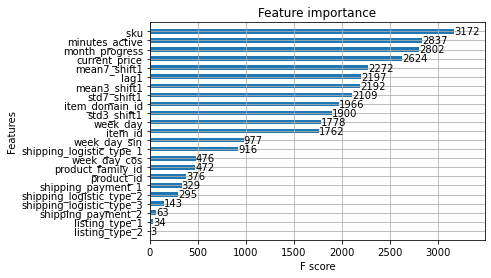

Elapsed time for training the model: 1.648340384165446 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 658.78 Mb (56.2% reduction)
Mem. usage decreased to 686.22 Mb (56.2% reduction)
Elapsed time for processing features: 3.217025899887085 min.
[0]	eval-rmsse:0.91600
[50]	eval-rmsse:0.81563
[100]	eval-rmsse:0.80796
[150]	eval-rmsse:0.80622
[200]	eval-rmsse:0.80512
[243]	eval-rmsse:0.80497


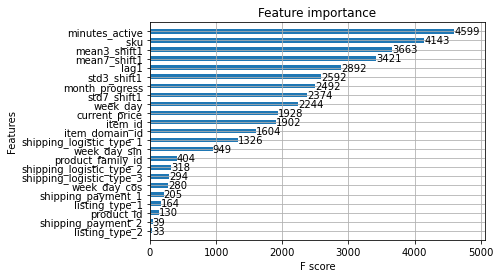

Elapsed time for training the model: 5.43656903107961 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 527.53 Mb (57.3% reduction)
Mem. usage decreased to 552.08 Mb (57.3% reduction)
Elapsed time for processing features: 2.851643268267314 min.
[0]	eval-rmsse:0.86247
[50]	eval-rmsse:0.76339
[100]	eval-rmsse:0.75659
[150]	eval-rmsse:0.75392
[200]	eval-rmsse:0.75250
[250]	eval-rmsse:0.75210
[300]	eval-rmsse:0.75182
[350]	eval-rmsse:0.75133
[400]	eval-rmsse:0.75106
[450]	eval-rmsse:0.75109
[453]	eval-rmsse:0.75110


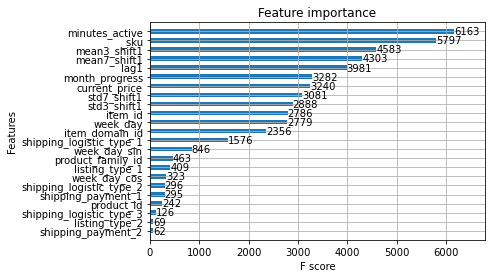

Elapsed time for training the model: 8.615696454048157 min.


In [15]:
models_by_site = list()
sites = ["MLA","MLB","MLM"]

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    valid_idx = train_data.query("ds > '2021-03-01'").index

    model = XGBoostForecaster(**model_kwargs)
    model.prepare_features(train_data, valid_idx)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    model.valid_features = reduce_mem_usage(model.valid_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    evaluator = RMSSE(train_data.loc[valid_idx, ["sku","y"]], scales)
    fit_kwargs = {
        "verbose_eval":50, 
        "feval":evaluator.evaluate, 
        "maximize":False,
    }
    model.fit(fit_kwargs=fit_kwargs)
    xgb.plot_importance(model.model.model, height=0.5)
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [16]:
errors = list()
sites = ["MLA","MLB","MLM"]
for site,model in zip(sites,models_by_site):
    error = model.model.model.best_score
    errors.append(error)
result = {
    "rmsse_MLA":errors[0], 
    "rmsse_MLB":errors[1],
    "rmsse_MLM":errors[2],
    "rmsse_AVG":np.mean(errors),
}
display(result)

{'rmsse_MLA': 0.763931,
 'rmsse_MLB': 0.804862,
 'rmsse_MLM': 0.751014,
 'rmsse_AVG': 0.773269}

In [17]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds<='2021-03-01'"))
    all_preds.append(preds)
train_preds = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 4min 56s, sys: 24.6 s, total: 5min 20s
Wall time: 1min 33s


In [18]:
train_preds = pd.merge(train_preds, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
train_preds["sq_error"] = train_preds.eval("(y-y_pred)**2")
train_errors = np.sqrt(train_preds.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
train_errors = pd.merge(train_errors, scales, how="inner", on="sku")
train_errors["rmsse"] = train_errors.eval("rmse/scale")
display(train_errors.groupby("site_id")["rmsse"].mean())
train_errors = train_errors.set_index("sku")

site_id
MLA    0.691042
MLB    0.702766
MLM    0.738490
Name: rmsse, dtype: float64

In [19]:
%%time
all_preds = list()
for site,model in zip(sites,models_by_site):
    preds = model.predict(dataset.query("site_id==@site & ds>'2021-03-01'"), recursive=True)
    all_preds.append(preds)
oof = pd.concat(all_preds, axis=0, ignore_index=True)

CPU times: user 9min 21s, sys: 1min 6s, total: 10min 27s
Wall time: 28min 34s


In [20]:
mrg = pd.merge(oof, dataset.loc[:,["ds","sku","site_id","y"]], how="inner", on=["ds","sku"])
mrg["sq_error"] = mrg.eval("(y-y_pred)**2")
valid_errors = np.sqrt(mrg.groupby(["sku","site_id"])["sq_error"].mean()).reset_index(name="rmse")
valid_errors = pd.merge(valid_errors, scales, how="inner", on="sku")
valid_errors["rmsse"] = valid_errors.eval("rmse/scale")
valid_errors.groupby("site_id")["rmsse"].mean()

site_id
MLA    0.786960
MLB    0.827192
MLM    0.782294
Name: rmsse, dtype: float64

In [21]:
train_errors.to_csv("../results/train_errors_xgb-m1.csv", index=False)
oof.to_csv("../results/oof_preds_xgb-m1.csv", index=False)

In [22]:
class InventoryDaysPredictor():

    def __init__(self, train, train_errors):
        self.train = train.copy(deep=True)
        self.train_errors = train_errors.copy(deep=True)

    def fit(self, preds):
        parameters = self.train.groupby('sku').agg({'y':['mean', 'std']}).y
        # replace nan means by overall mean
        idx = parameters[parameters["mean"].isna()].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        # replace zero means by overall mean
        idx = parameters[parameters["mean"] == 0].index
        parameters.loc[idx, "mean"] = parameters["mean"].mean()
        
        # replace nan stds by overall std
        idx = parameters[parameters["std"].isna()].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        # replace nan stds by overall std
        idx = parameters[parameters["std"] == 0].index
        parameters.loc[idx,"std"] = parameters["std"].mean()
        
        self.parameters = parameters.to_dict()

        predictors = dict()
        days = np.arange(1,31)
        for sku,df in tqdm(preds.groupby("sku")):
            cumpred = df.y_pred.values.cumsum()
            interp = interpolate.interp1d(cumpred, days, bounds_error=False, fill_value=(-np.inf,np.inf))
            predictors[sku] = interp
        self.predictors = predictors

    def predict(self, sku, stock):
        mean = self.parameters['mean'][sku]
        std = self.parameters['std'][sku]
        days_to_stockout = float(np.clip(self.predictors[sku](stock), a_min=1, a_max=30))
        std_days = std/mean
        return days_to_stockout,std_days

    def predict_proba(self, sku, stock, dist_kwargs, lambda1, lambda2):
        days_to_stockout,std_days = self.predict(sku, stock)
        scale = std_days * (lambda1*(days_to_stockout**lambda2))
        days = np.arange(1,31)
        probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, **dist_kwargs)
        #if prob is zero, replace with uniform
        if np.sum(probs) == 0: return np.ones(30) / 30
        return probs/np.sum(probs)

In [23]:
predictor = InventoryDaysPredictor(dataset.query("ds <= '2021-03-01'"), train_errors)
predictor.fit(oof)

100%|██████████| 496797/496797 [01:07<00:00, 7367.51it/s]


***
## Assessment of invetory days prediction

In [24]:
valid = pd.read_csv(f"{input_path}/validation_seed2.csv")

preds = list()
for sku,df in tqdm(valid.groupby("sku")):
    preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
preds = pd.DataFrame(preds, columns=["days_to_stockout"])

 23%|██▎       | 116664/496797 [00:19<01:02, 6036.25it/s]/Users/mavillan/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 496797/496797 [01:25<00:00, 5832.69it/s]


RMSE (mean):  13.26596311228159
RMSE (median):  9.0
MAE (mean):  10.595006495157687
MAE (median):  9.0


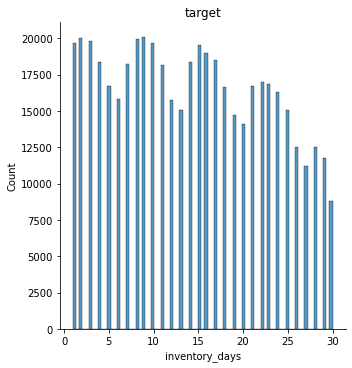

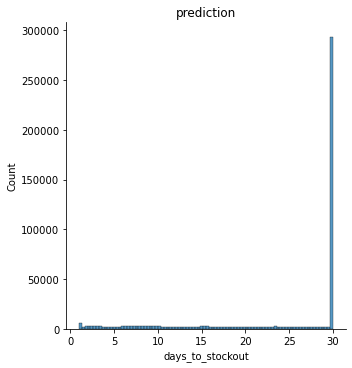

In [25]:
print("RMSE (mean): ", np.sqrt(np.mean((preds.days_to_stockout - valid.inventory_days)**2)) )
print("RMSE (median): ", np.sqrt(np.median((preds.days_to_stockout - valid.inventory_days)**2)) )
print("MAE (mean): ", np.mean(np.abs(preds.days_to_stockout - valid.inventory_days)))
print("MAE (median): ", np.median(np.abs(preds.days_to_stockout - valid.inventory_days)))

sns.displot(valid.inventory_days)
plt.title("target")
plt.show()

sns.displot(preds.days_to_stockout)
plt.title("prediction")
plt.show()

***
## Assessment of RPS

In [26]:
beta = 0.634505
lambda1 = 0.458712
lambda2 = 0.967726

In [27]:
valid_files = [fn for fn in glob("../data/validation_seed*.csv") if "seed2.csv" not in fn]
results = list()

for files in valid_files:
    valid = pd.read_csv(files)
    
    preds_proba = list()
    for sku,df in tqdm(valid.groupby("sku")):
        preds_proba.append(predictor.predict_proba(
            sku, 
            stock=df.target_stock.values[0],
            dist_kwargs={"beta":beta},
            lambda1=lambda1, 
            lambda2=lambda2,
        ))
    preds_proba = np.array(preds_proba)
    
    rps = scoring_function(valid.inventory_days.values, preds_proba)
    results.append({"file":files.split("/")[-1].split(".")[0], "rps":rps})
    print({"file":files.split("/")[-1].split(".")[0], "rps":rps})

 48%|████▊     | 239193/496797 [01:19<01:25, 3014.99it/s]/Users/mavillan/miniconda3/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 496797/496797 [02:45<00:00, 3001.47it/s]


{'file': 'validation_seed19', 'rps': 4.384997877622492}


100%|██████████| 496797/496797 [02:46<00:00, 2987.43it/s]


{'file': 'validation_seed23', 'rps': 4.386488406171153}


100%|██████████| 496797/496797 [02:45<00:00, 2995.40it/s]


{'file': 'validation_seed17', 'rps': 4.386752438906541}


In [28]:
pd.DataFrame(results)

,file,rps
0,validation_seed19,4.384998
1,validation_seed23,4.386488
2,validation_seed17,4.386752


In [29]:
# cleanup ram
del models_by_site
gc.collect()

0

***
## model training

In [30]:
unpredictable = pd.read_csv(f"{input_path}/unpredictable.csv")

dataset = (
    pd.read_parquet(f"{input_path}/train.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds", "sold_quantity":"y"}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(dataset)/1e6)
print("nskus:", dataset.sku.nunique())

nrows: 36.594396
nskus: 635633


In [31]:
test = (
    pd.read_parquet("../data/test.parquet")
    .query("sku not in @unpredictable.sku")
    .rename({"date":"ds",}, axis=1,)
    .sort_values(["sku","ds"])
    .reset_index(drop=True)
)
print("nrows:", len(test)/1e6)
print("nskus:", test.sku.nunique())

nrows: 15.78567
nskus: 526189


------------------------------------------------------------------------------------------
Preparing model for site: MLA
Mem. usage decreased to 286.67 Mb (56.2% reduction)
Elapsed time for processing features: 0.8275744160016377 min.
[04:23:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




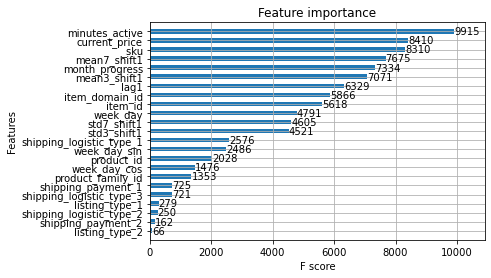

Elapsed time for training the model: 4.674276403586069 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLB
Mem. usage decreased to 1693.07 Mb (56.2% reduction)
Elapsed time for processing features: 5.262322533130646 min.
[04:33:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




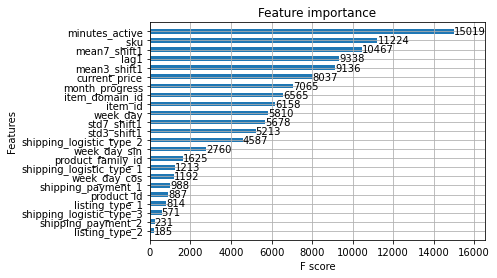

Elapsed time for training the model: 24.96858644882838 min.
------------------------------------------------------------------------------------------
Preparing model for site: MLM
Mem. usage decreased to 1349.73 Mb (57.3% reduction)
Elapsed time for processing features: 4.019956688086192 min.
[05:02:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




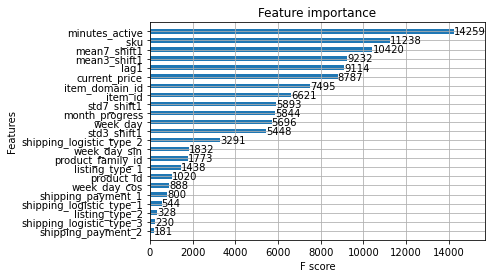

Elapsed time for training the model: 19.766112116972604 min.


In [32]:
models_by_site = list()
sites = [
    "MLA",
    "MLB",
    "MLM",
]
num_iterations = {
    "MLA": 300,
    "MLB": 250,
    "MLM": 450,
}

for site in sites:
    print("-"*90)
    print(f"Preparing model for site: {site}")

    tic = time.time()
    train_data = dataset.query("site_id == @site").reset_index(drop=True)
    
    _model_kwargs = dict(model_kwargs)
    _model_kwargs["model_params"]["num_iterations"] = num_iterations[site]

    model = XGBoostForecaster(**_model_kwargs)
    model.prepare_features(train_data)
    model.train_features = reduce_mem_usage(model.train_features, verbose=True)
    gc.collect()
    tac = time.time()
    print(f"Elapsed time for processing features: {(tac-tic)/60} min.")

    tic = time.time()
    model.fit()
    xgb.plot_importance(model.model.model, height=0.5)
    plt.show()
    models_by_site.append(model)
    tac = time.time()
    print(f"Elapsed time for training the model: {(tac-tic)/60} min.")


In [33]:
preds_by_site = list()

for site,model in tqdm(zip(sites,models_by_site)):
    preds = model.predict(test.query("site_id == @site"), recursive=True)
    preds_by_site.append(preds)
    
predictions = pd.concat(preds_by_site, ignore_index=True)
predictions.to_csv(f"../results/preds_m1_xgb_sub{SUB_NBR}.csv", index=False)

3it [30:36, 612.23s/it]


In [34]:
# todo: fix train_errors
predictor = InventoryDaysPredictor(dataset, train_errors)
predictor.fit(predictions)

100%|██████████| 526189/526189 [01:09<00:00, 7521.73it/s]


100%|██████████| 526189/526189 [01:27<00:00, 5984.14it/s]


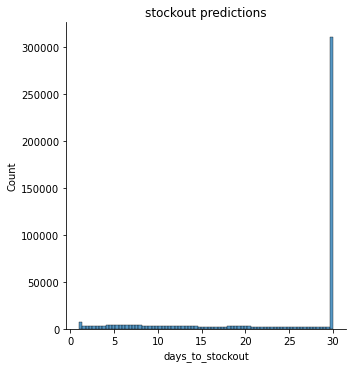

In [35]:
stockout_preds = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    stockout_preds.append(predictor.predict(sku, df.target_stock.values[0])[0])
stockout_preds = pd.DataFrame(stockout_preds, columns=["days_to_stockout"])

sns.displot(stockout_preds.days_to_stockout)
plt.title("stockout predictions")
plt.show()

0.634505 0.458712 0.967726


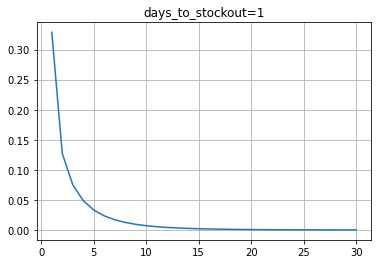

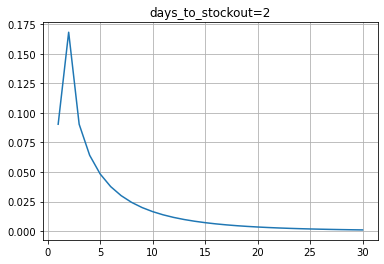

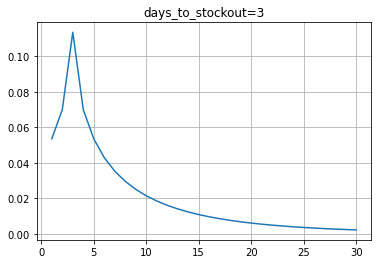

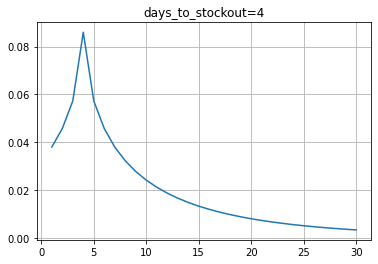

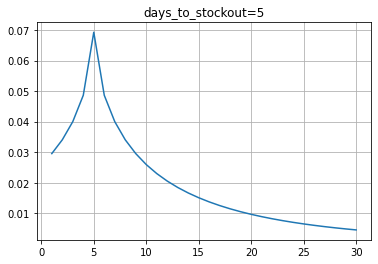

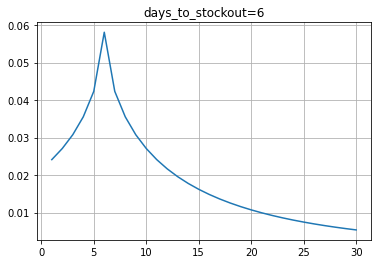

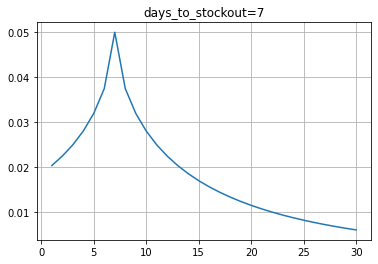

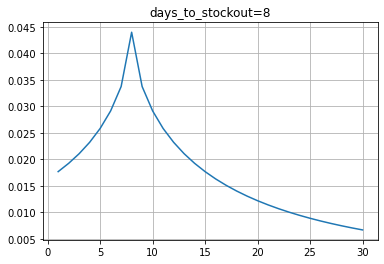

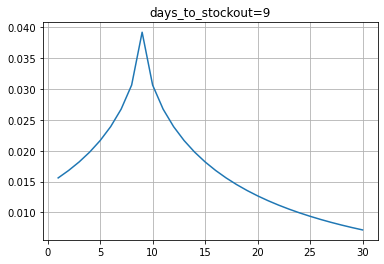

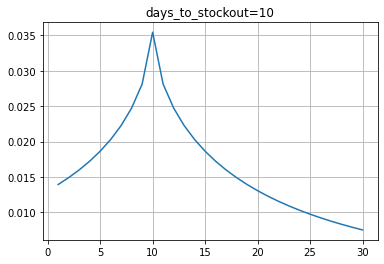

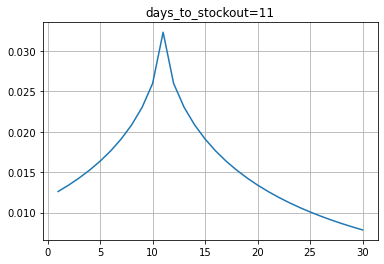

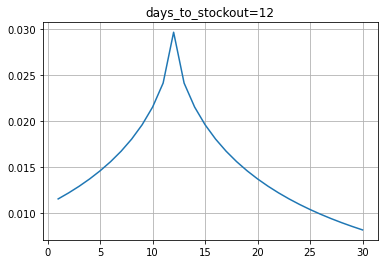

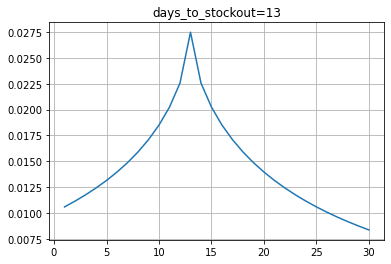

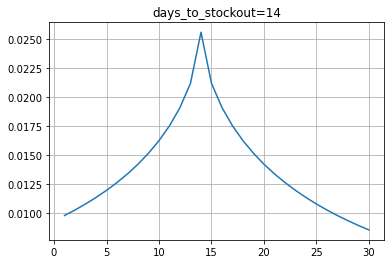

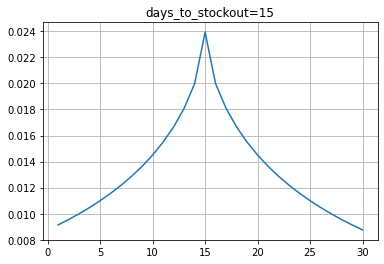

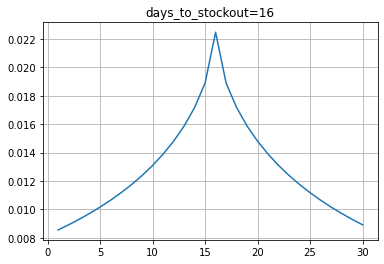

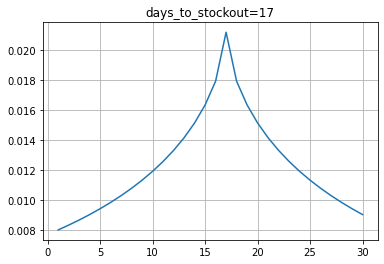

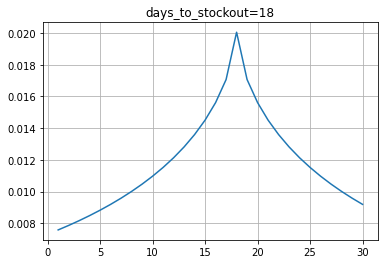

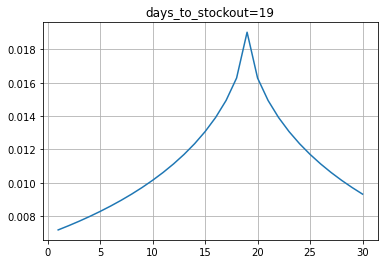

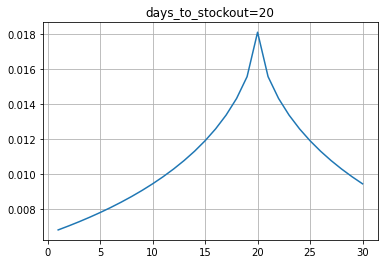

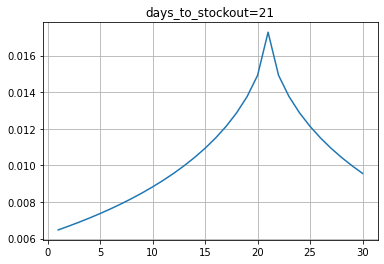

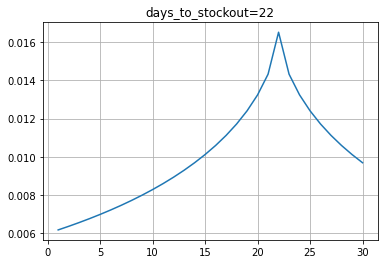

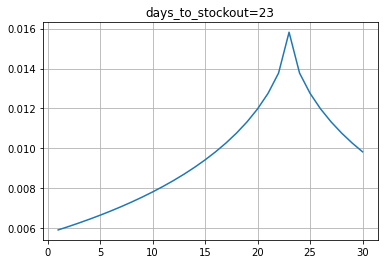

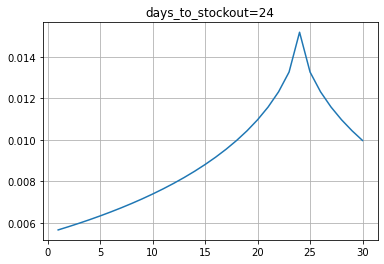

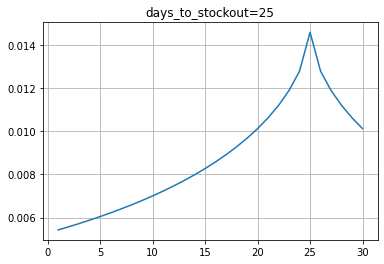

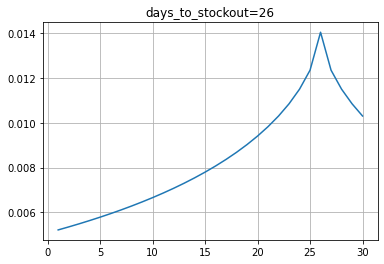

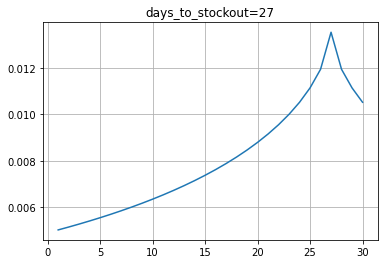

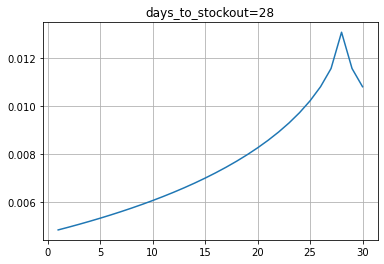

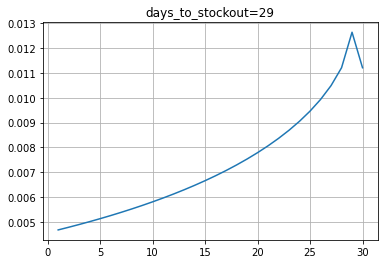

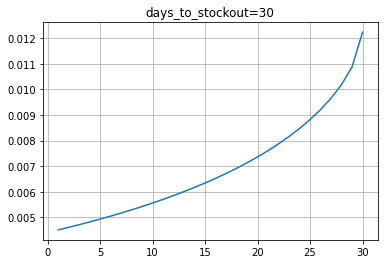

In [36]:
print(beta, lambda1, lambda2)
std_days = np.mean(np.asarray(list(predictor.parameters["std"].values())) / np.asarray(list(predictor.parameters["mean"].values())))

for days_to_stockout in range(1,31):
    scale = std_days * (lambda1*(days_to_stockout**lambda2))
    days = np.arange(1,31)
    probs = stats.gennorm.pdf(days, loc=days_to_stockout, scale=scale, beta=beta)
    
    plt.plot(days, probs)
    plt.grid()
    plt.title(f"days_to_stockout={days_to_stockout}")
    plt.show()

In [37]:
skus = list()
preds_proba = list()
groups = (
    test[["sku","target_stock"]]
    .drop_duplicates()
    .groupby("sku")
)

for sku,df in tqdm(groups):
    skus.append(sku)
    preds_proba.append(predictor.predict_proba(
        sku, 
        stock=df.target_stock.values[0],
        dist_kwargs={"beta":beta},
        lambda1=lambda1, 
        lambda2=lambda2,
    ))
preds_proba = np.array(preds_proba)
preds_proba = pd.DataFrame(preds_proba, index=skus)

100%|██████████| 526189/526189 [02:53<00:00, 3040.82it/s]


In [38]:
unpreds_proba = np.ones((len(unpredictable),30)) / 30
unpreds_proba = pd.DataFrame(unpreds_proba, index=unpredictable.sku.values)

preds_proba_mrg = pd.concat([preds_proba, unpreds_proba])
preds_proba_mrg

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.027215,0.028422,0.029731,0.031159,0.032728,0.034468,0.036421,0.038650,0.041257,0.044432,0.048649,0.055060,0.047951,0.043937,0.040860,0.038315,0.036130,0.034211,0.032497,0.030949,0.029540,0.028246,0.027052,0.025945,0.024915,0.023952,0.023050,0.022202,0.021403,0.020650
1,0.020942,0.021442,0.021961,0.022500,0.023060,0.023643,0.024249,0.024882,0.025542,0.026231,0.026952,0.027708,0.028501,0.029335,0.030213,0.031140,0.032122,0.033163,0.034273,0.035459,0.036732,0.038107,0.039602,0.041241,0.043057,0.045102,0.047458,0.050274,0.053916,0.061192
2,0.025573,0.025934,0.026305,0.026686,0.027078,0.027482,0.027898,0.028328,0.028771,0.029229,0.029704,0.030195,0.030705,0.031235,0.031786,0.032362,0.032963,0.033593,0.034256,0.034954,0.035694,0.036481,0.037323,0.038232,0.039222,0.040317,0.041554,0.043000,0.044822,0.048319
3,0.022174,0.022643,0.023129,0.023632,0.024152,0.024693,0.025254,0.025837,0.026443,0.027075,0.027735,0.028423,0.029143,0.029898,0.030690,0.031524,0.032403,0.033333,0.034320,0.035371,0.036495,0.037704,0.039013,0.040441,0.042016,0.043781,0.045802,0.048205,0.051289,0.057381
5,0.021050,0.021548,0.022064,0.022600,0.023157,0.023736,0.024339,0.024967,0.025623,0.026307,0.027023,0.027773,0.028560,0.029386,0.030257,0.031176,0.032148,0.033180,0.034279,0.035452,0.036713,0.038073,0.039551,0.041170,0.042965,0.044984,0.047309,0.050087,0.053677,0.060843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393191,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
262125,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
393209,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
131068,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


***
## generate submission

In [39]:
test = pd.read_csv("../data/test_data.csv")
preds_proba_mrg = preds_proba_mrg.loc[test.sku.values,:].copy()

In [40]:
assert preds_proba_mrg.isna().sum(axis=1).sum() == 0
assert np.allclose(preds_proba_mrg.sum(axis=1).values, 1, atol=1e-16)
assert preds_proba_mrg.max(axis=1).max() < 1

In [41]:
(preds_proba_mrg
 .round(4)
 .to_csv(f"../subs/sub{SUB_NBR}.csv.gz", header=False, index=False, compression="gzip")
)

***